In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset,Subset
import torchvision.transforms as transforms
import torchvision.models as models
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
# train = pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/train.csv')
# test =pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/test.csv')
# val_size = int(0.2 * len(train))
# train_size=len(train)-val_size
# train, valid = random_split(train,[train_size, val_size])

In [3]:
cuda = True if torch.cuda.is_available() else False

In [4]:
train=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/train.csv")
test=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/test.csv")
train_x=train.drop(['id','y'],axis=1).values
train_y=train['y'].values


In [5]:
class FADataset(Dataset):
    def __init__(self, x,y):
        super().__init__()
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
        self.flag= [False] * len(self.x)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target,idx

    def update_loss_value(self, idx):
        self.flag[idx] = True
        

In [6]:
batch_size=80
para={
    "shuffle":True,
    "batch_size":batch_size
}
dataset=FADataset(train_x,train_y)
trainset, validset = random_split(dataset, [0.8, 0.2])
train_dl= DataLoader(trainset, **para)
valid_dl= DataLoader(validset,**para)
test_dl= DataLoader(test, **para)


In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3,num_hidden4, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.ReLU(True),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.ReLU(True),
                                nn.Linear(num_hidden3,num_hidden4),
                                nn.Linear(num_hidden4,output_dim)
                                )
    def forward(self, x):
        return self.model(x)


In [8]:
model=[]
optimizer=[]
for i in range(3):
    model.append(MLP(input_dim=2, num_hidden1=80,num_hidden2=128,num_hidden3=256,num_hidden4=128, output_dim=1))
    optimizer.append(torch.optim.Adam(model[i].parameters(), lr=0.001))
criterion = nn.MSELoss()



In [9]:
num_epochs = 30
losses=[]
size = len(train_dl)
model[0].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(train_dl):
        outputs = model[0](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[0].zero_grad()
        loss.backward()
        optimizer[0].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())


loss: 1.216267 
loss: 0.101991 
loss: 0.093449 
loss: 0.071041 
loss: 0.082841 
loss: 0.040018 
loss: 0.037706 
loss: 0.039817 
loss: 0.031286 
loss: 0.023831 
loss: 0.034237 
loss: 0.025733 
loss: 0.035751 
loss: 0.043008 
loss: 0.032537 
loss: 0.030046 
loss: 0.037366 
loss: 0.020520 
loss: 0.021840 
loss: 0.025248 
loss: 0.037702 
loss: 0.025132 
loss: 0.028542 
loss: 0.028713 
loss: 0.022549 
loss: 0.026596 
loss: 0.025752 
loss: 0.027867 
loss: 0.032578 
loss: 0.023332 


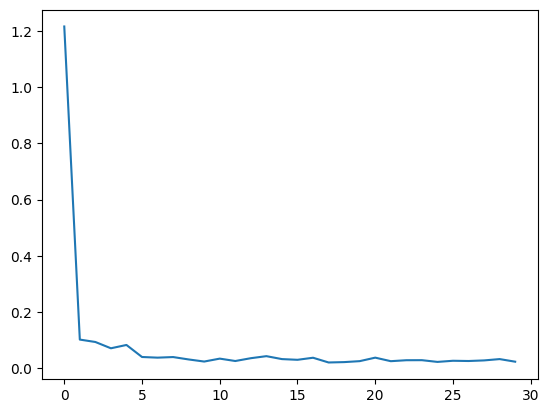

In [10]:
plt.plot(losses)

In [11]:
model[0].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[0](data)
    loss = criterion(outputs, target)
print(f"loss: {loss.item():>7f} ")

loss: 0.250956 


c:\Users\MJ\anaconda3\envs\MJ\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [12]:
model[0].eval()
indexF=[]
indexT=[]
for i in range(len(trainset)):
    outputs = model[0](trainset.dataset.x[i])
    loss = criterion(outputs,trainset.dataset.y[i].reshape(1))
    if(loss>0.17):
        indexF.append(i)
    else:
        indexT.append(i)

In [13]:
Fdataset=torch.utils.data.Subset(trainset, indexF)
Tdataset=torch.utils.data.Subset(trainset, indexT)
Fdl=DataLoader(Fdataset,**para)
Tdl=DataLoader(Tdataset,**para)


In [14]:
num_epochs = 30
size = len(train_dl)
model[1].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(Fdl):
        outputs = model[1](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[1].zero_grad()
        loss.backward()
        optimizer[1].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

loss: 1.062196 
loss: 0.560935 
loss: 0.233882 
loss: 0.185426 
loss: 0.269411 
loss: 0.185709 
loss: 0.152082 
loss: 0.188709 
loss: 0.218089 
loss: 0.204476 
loss: 0.180325 
loss: 0.148394 
loss: 0.140372 
loss: 0.165249 
loss: 0.180450 
loss: 0.159095 
loss: 0.133626 
loss: 0.143140 
loss: 0.143721 
loss: 0.148302 
loss: 0.139898 
loss: 0.136884 
loss: 0.136334 
loss: 0.136337 
loss: 0.134569 
loss: 0.137535 
loss: 0.128570 
loss: 0.127338 
loss: 0.124240 
loss: 0.117230 


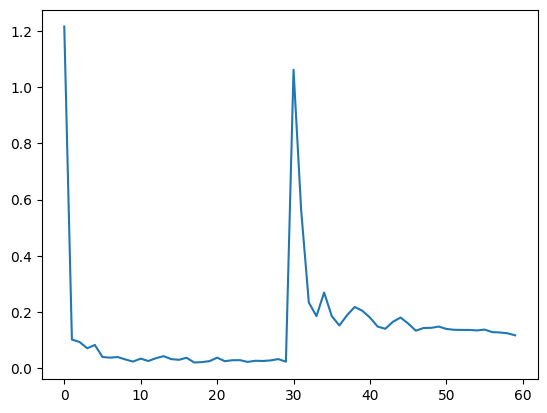

In [15]:
plt.plot(losses)

In [16]:
model[1].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[1](data)
    loss = criterion(outputs, target)
print(f"loss: {loss.item():>7f} ")

loss: 0.179505 
